<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/quantum_gradients/universal_qubit_classifier_using_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit -q --upgrade

     |████████████████████████████████| 2.7MB 9.3MB/s 
     |████████████████████████████████| 18.2MB 130kB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 102kB 17.0MB/s 
     |████████████████████████████████| 1.4MB 61.7MB/s 
     |████████████████████████████████| 51kB 10.0MB/s 
     |████████████████████████████████| 5.6MB 29.0MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 71kB 12.5MB/s 
     |████████████████████████████████| 573kB 52.7MB/s 
     |████████████████████████████████| 24.3MB 1.3MB/s 
     |████████████████████████████████| 2.3MB 60.5MB/s 


In [0]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info.analysis import average_data
from qiskit.quantum_info import state_fidelity
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report
import numpy as np
from tqdm import tqdm 
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt

In [0]:
n_qubits = 1
layers = 5
n_samples = 800

In [0]:
def cerate_data(n_qubits,layers,dataset_name,n_samples,test_size = 0.1,plot=True,normalize=True):

  """
  this fucntion takes 4 main inputs:
  n_qubits: int 1,....,n
  layers: int 1,....,n
  dataset_name: str like 'moons'
  n_samples: int 2,......,n
  test_size: float between 0 and 1

  it returns the training and the testing dataset with their labels and also the 
  corrosponding target states and also the weights for training the classifier
  """

  # creating circles dataset taken from: https://github.com/AdrianPerezSalinas/universal_qlassifier/blob/master/data_gen.py

  def _circle(n_samples):
    centers = np.array([[0, 0]])
    radii = np.array([np.sqrt(1.8/np.pi)])
    data=[]
    dim = 2
    labels=[]
    np.random.seed(1000)
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii):  
            if np.linalg.norm(x - c) < r:
                y = 1 

        data.append(x)
        labels.append(y)
            
    return np.array(data), np.array(labels)

  if dataset_name.lower() == 'moons':
    data,labels = make_moons(n_samples=n_samples,random_state=0,noise=0.04)
  
  if dataset_name.lower() == 'circles':
    data,labels = _circle(n_samples)

  x_train,x_test,y_train,y_test = train_test_split(data,labels,stratify=labels,test_size=test_size,random_state=0) # splitting data evenly

  if normalize: # scale features  [-1:1]

    if len(x_train.shape) == 1: #check for dimension to prevent any error from scaling
      x_train = x_train.reshape(-1,1)
      x_test = x_test.reshape(-1,1)

    scale = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
    x_train = scale.transform(x_train)
    x_test = scale.transform(x_test)
  
  #check features' dimensions and make it 3 or its multiples
  if len(x_train)<3 or len(x_train) > 6:

    if x_train.shape[1] == 2:

      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1)))

    if x_train.shape[1] == 1:
      
      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1),np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1),np.zeros(len(x_test)).reshape(-1,1)))
    
    if x_train.shape[1] == 4:
      
      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1),np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1),np.zeros(len(x_test)).reshape(-1,1)))

    if x_train.shape[1] == 5:

      x_train = np.hstack((x_train,np.zeros(len(x_train)).reshape(-1,1)))
      x_test = np.hstack((x_test,np.zeros(len(x_test)).reshape(-1,1)))
    if x_train.shape[1] > 6:
      raise ValueError("please create a dataset whose number of features are divisible by 3 as there is no checking mechanisim implemented for values bigger than 6")

  # prepare target states based on number of labels, currently only two-label is implemented

  n_of_labels = len(np.unique(labels))

  state_labels = np.zeros((n_of_labels,2**n_qubits),dtype=np.complex128)

  if n_of_labels == 2:
    state_labels[0,0] = 1
    state_labels[-1,-1] = 1

  # initialize weights  
  np.random.seed(100) #to make results reproducible
  weights = np.random.rand(n_qubits,layers,3)
  
  if plot:
    plt.scatter(x_train[:,0][y_train==0], x_train[:,1][y_train==0], marker='o', 
                color='red', label='class 0')
    plt.scatter(x_train[:,0][y_train==1], x_train[:,1][y_train==1], marker='*', 
                color='blue', label='class 1')
    plt.legend()
    plt.show()

  return (x_train,y_train),(x_test,y_test),state_labels,weights


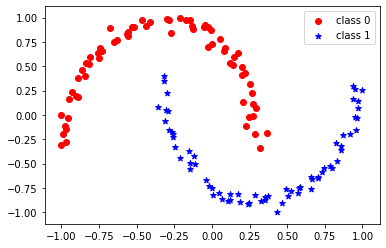

In [4]:
(x_train,y_train),(x_test,y_test),State_labels,weights = cerate_data(1,6,'moons',150,test_size=0.1)

In [6]:
x_train.shape

(135, 3)

In [0]:
def circuit(params,X,State_labels=State_labels):

    """

    this function takes 3 inputs:

    params: array like that determines the number of qubits and the number of layers
    X: a single sample that contains the features
    State_labels: are the target states created from create_data()    
    it returns the fidelities from the two target states in a list

    """


    
    n_qubits = len(params)
    layers = len(params[0][0])
    qc = QuantumCircuit(n_qubits)
    
    n_features = len(X)

    for qubit in range(len(params)):
        
        for id,layer in enumerate(params[qubit]):
           
            for index in range(0,n_features,3):
              qc.u3(X[index],X[index+1],X[index+2],qubit)
              
            qc.u3(layer[0],layer[1],layer[2],qubit)
            
            if n_qubits > 1 and (id < layers-1):
                qc.cz(0,1)
                
    backend_sim = Aer.get_backend('statevector_simulator')

    job_sim = execute(qc, backend_sim)

    result_sim = job_sim.result()
    
    state_vector = result_sim.get_statevector(qc)
    fid_1 = state_fidelity(state_vector,State_labels[0])
    fid_2 = state_fidelity(state_vector,State_labels[1])
    #print(average_data(counts,vals))
    return [fid_1,fid_2]

In [0]:
def cost(params,X,y,State_labels):
    """
    params: array like that determines the number of qubits and the number of layers
    
    X: samples that contain the features
    
    y: are the labels for that sample    

    State_labels: are the target states created from create_data()

    this function returns the binary cross entropy cost from the computed fidelities and corresponding labels
    """
    value = []
    
    for i in range(len(X)):
        value.append(circuit(params,X[i],State_labels))

    res = log_loss(y,value,labels=y_train)
   # print(res)
    return res
        

In [0]:
def gradient(params,x,y,State_labels):
    """
    this function computes the gradients for each varaible in the quantum circuit
    it takes:
    x: a single sample
    y: the corresponding label
    State_labels: are the target states created from create_data()
    """
    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                
        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
                
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi/2
    
                F2 = cost(params,x,y,State_labels)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [0]:
def optimize(params,X,y,lr,State_labels):
    
    g = gradient(params,X,y,State_labels)
    
    new_weights = params - (lr*g)
    
    return new_weights

In [0]:
def predict(params,X):

    fid_1,fid_2 = circuit(params,X)


    if fid_1 > fid_2:
      
      return abs(1-fid_1)
    
    else:

      return fid_2
    

In [0]:
np.random.seed(100)
loss = np.inf
lr = 0.2
test_loss = []
epochs = 400
batch_size = 20
for it in tqdm(range(epoch)):


    # create random indices every iteration "stochastic gradient descent way not mini batch because of long time" 
    index = np.random.randint(0,len(x_train),batch_size)
    x_batch,y_batch = x_train[index],y_train[index]
    # if you want to decay lr uncomment the following and edit it the way you want 
    #if i+1 == 500 or i+1 == 800:
     #   lr = lr - 0.05
    weights = optimize(weights,x_batch,y_batch,lr,State_labels)
    
    res = cost(weights,x_test,y_test,State_labels)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = weights
    print(
        "Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

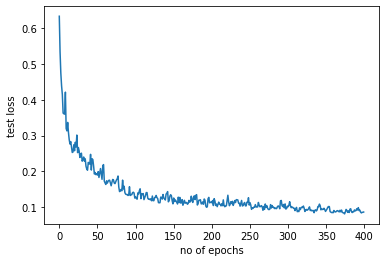

In [44]:
plt.xlabel('no of epochs')
plt.ylabel('test loss')
plt.plot(range(epochs),test_loss)
plt.show()

In [0]:
pred = []
for j in range(len(x_train)):
    pred.append(predict(var,x_train[j]))

In [24]:
print(accuracy_score(np.array(pred).round(),y_train))
print(classification_report(np.array(pred).round(),y_train))


1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        67
         1.0       1.00      1.00      1.00        68

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



In [0]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 50), np.linspace(-2, 2, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
X_grid = np.hstack((X_grid,np.zeros(len(X_grid)).reshape(-1,1)))
predictions_grid = [predict(var, x) for x in X_grid]

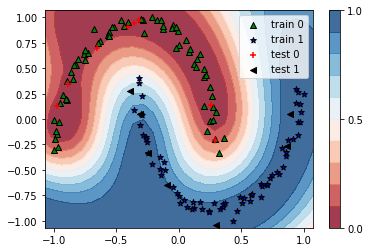

In [42]:
Z = np.reshape(np.array(predictions_grid), xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])
plt.scatter(x_train[:, 0][y_train==0], x_train[:, 1][y_train==0], c='g', marker='^', edgecolors='k',label='train 0')
plt.scatter(x_train[:, 0][y_train==1], x_train[:, 1][y_train==1], c='b', marker='*', edgecolors='k',label='train 1')
plt.scatter(x_test[:, 0][y_test==0], x_test[:, 1][y_test==0], c='r', marker='+', edgecolors='k',label='test 0')
plt.scatter(x_test[:, 0][y_test==1], x_test[:, 1][y_test==1], c='black', marker='<', edgecolors='k',label='test 1')

plt.ylim(-1.07, 1.07)
plt.xlim(-1.07, 1.07)
plt.legend()
plt.savefig('decision_b.png',dpi=700)
plt.show()
